# Семинар 5. Мультиклассовая классификация

Рассмотрим вновь датасет ["Ирисы Фишера"](https://ru.wikipedia.org/wiki/Ирисы_Фишера). Изначальная задача классификации заключалась в определении одного из трёх классов, наша задача используя методы бинарной классификации решить многоклассовую задачу.
[<img src="https://miro.medium.com/max/1000/1*Hh53mOF4Xy4eORjLilKOwA.png" alt="drawing" width="800"/>](https://miro.medium.com/max/1000/1*Hh53mOF4Xy4eORjLilKOwA.png)

Два базовых подхода к решению проблемы:
* **one-versus-all**
    * $\forall c=1,2,...C$ обучим бинарный классификатор на всех объектах с метками $\mathbb{I}[y_{n}=c]$
    * Предсказываем класс, классификатор которого дал "большее значение"
* **one-versus-one**
    * $\forall i,j\in[1,2,...C],$ $i\ne j$ обучим бинарный классификатор на объектах с метками $y_{n}\in\{i,j\}$,
    * Предсказываем класс, классификатор которого дал "большее значение" из $C(C-1)/2$ классификаторов,

<img src="data/img.png" alt="drawing" width="500"/>

In [72]:
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris

In [73]:
iris = load_iris(as_frame=True)
data = iris['data']

In [74]:
X = iris['data']
y = iris['target'].values

In [75]:
from sklearn.model_selection import train_test_split

# делим данные на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

In [76]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
ss.fit(X_train) # считаем \mu и \sigma

# делаем преобразование данных
X_train_ss = ss.transform(X_train)
X_test_ss = ss.transform(X_test)

In [77]:
X._mgr.items

Index(['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)',
       'petal width (cm)'],
      dtype='object')

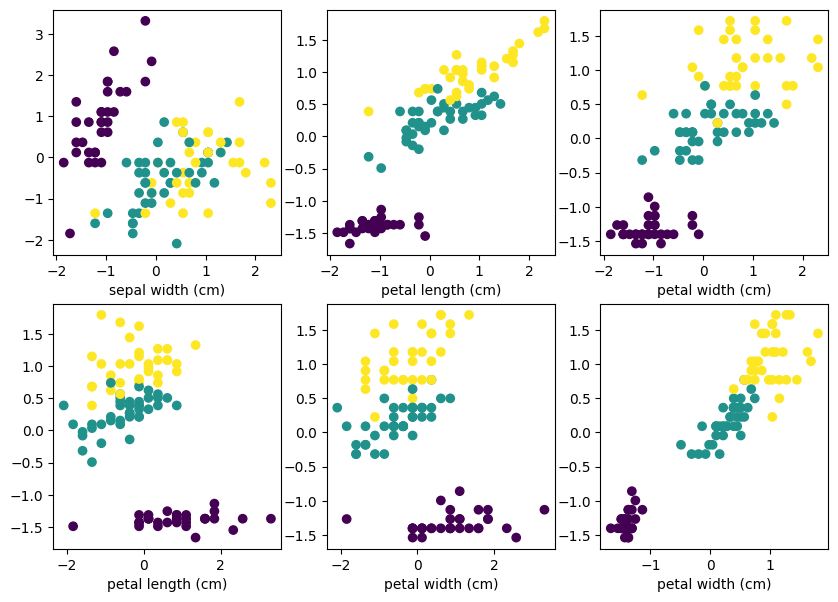

In [78]:
n = X_train_ss.shape[1]
fig, axs = plt.subplots(2, 3, figsize=(10, 7))
c = 0
for i in range(4):
    for j in range(i+1, 4):
        axs[c // 3, c % 3].scatter(X_train_ss[:,i], X_train_ss[:,j], c=y_train)
        axs[c // 3, c % 3].set_xlabel(X.columns[i])
        axs[c // 3, c % 3].set_xlabel(X.columns[j])
        c += 1
plt.show()

Попробуем реализовать one-versus-all подход

In [79]:
import numpy as np

In [80]:
from sklearn.linear_model import LogisticRegression

class MuticlassLogisticRegression:
    def __init__(self, num_classes):
        self.num_classes = num_classes
        self.clfs = [LogisticRegression() for i in range(self.num_classes)]
        
    def fit(self, X_train, y_train):
        for i, clf in enumerate(self.clfs):
            clf.fit(X_train, (y_train == i).astype(int))
    
    def predict(self, X_test):
        preds = np.array([[clf.decision_function(X_test)] for clf in self.clfs])
        return np.argmax(preds,axis=0)

In [81]:
model = MuticlassLogisticRegression(3)
model.fit(X_train_ss, y_train)

In [82]:
y_pred = model.predict(X_test_ss)
y_pred

array([[1, 2, 2, 1, 0, 2, 1, 0, 0, 1, 2, 0, 1, 2, 2, 2, 0, 0, 1, 0, 0, 1,
        0, 2, 0, 0, 0, 2, 2, 0, 2, 1, 0, 0, 1, 1, 2, 0, 0, 1, 1, 0, 2, 2,
        2]])

In [83]:
y_test

array([1, 2, 2, 1, 0, 2, 1, 0, 0, 1, 2, 0, 1, 2, 2, 2, 0, 0, 1, 0, 0, 2,
       0, 2, 0, 0, 0, 2, 2, 0, 2, 2, 0, 0, 1, 1, 2, 0, 0, 1, 1, 0, 2, 2,
       2])

In [84]:
from mlxtend.plotting import plot_decision_regions

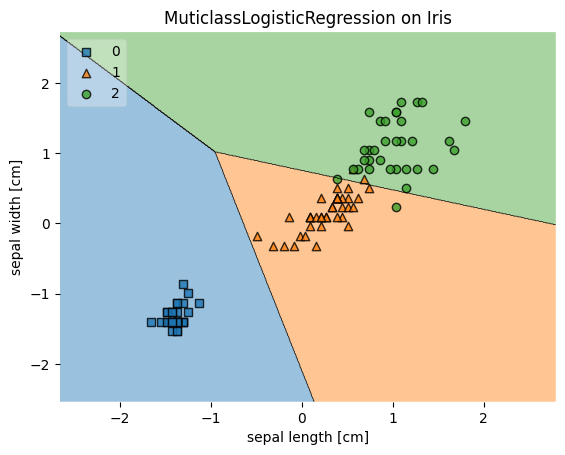

In [85]:
plot_model = MuticlassLogisticRegression(3)
plot_model.fit(X_train_ss[:, [2,3]], y_train)
plot_decision_regions(X_train_ss[:, [2,3]], y_train, clf=plot_model, legend=2)
plt.xlabel('sepal length [cm]')
plt.ylabel('sepal width [cm]')
plt.title('MuticlassLogisticRegression on Iris')
plt.show()

Остается много вопросов:
* Какие проблемы могут возникать из-за того что мы обучаем много классификаторов?
* Как выглядит пространство предсказаний?
* Как адаптировать метрики из бинарного случая?

**One versus all dilemma:**
<img src="data/one_versus_all_fails.png" alt="drawing" width="500"/>
**One versus one dilemma:**
<img src="data/one_versus_one_fails.png" alt="drawing" width="500"/>


## Метрики мультиклассовой классфикации

In [86]:
from sklearn.metrics import classification_report

In [89]:
# https://towardsdatascience.com/multi-class-metrics-made-simple-part-ii-the-f1-score-ebe8b2c2ca1
print(classification_report(y_test, y_pred[0]))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        18
           1       0.83      1.00      0.91        10
           2       1.00      0.88      0.94        17

    accuracy                           0.96        45
   macro avg       0.94      0.96      0.95        45
weighted avg       0.96      0.96      0.96        45



## Мультиклассовая классификация как задача оптимизации

Каждый класс обладает своей моделью, а значит своиим весами:

$$
\begin{cases}
score(\omega_{1}|x)=w_{1}^{T}x + w_{0,1} \\
score(\omega_{2}|x)=w_{2}^{T}x + w_{0,2}\\
\cdots\\
score(\omega_{C}|x)=w_{C}^{T}x + + w_{0,C}
\end{cases}
$$

Тогда вероятность в терминах скора мы можем выразить следующим образом:

$$p(\omega_{c}|x)=softmax(\omega_c|W, x)=\frac{exp(w_{c}^{T}x + w_{0,c})}{\sum_{i}exp(w_{i}^{T}x + w_{0,i})}$$

В то же время оценка максимального правдоподобия будет:
$$\prod_{n=1}^{N}\prod_{c=1}^{C} softmax(\omega_c|W, x_n)^{\mathbb{I}[y_n = w_c]}$$
Что на деле опять переписывается в вид кросс-энтропии:
$$L(w) = - \sum_{n=1}^N\sum_{c=1}^{C} \mathbb{I}[y_n = w_c]\cdot\ln{\sigma(w_c^{T}x_n+w_{c,0}))}$$

## Метод опорных векторов (SVM)

Источник: https://github.com/AsyaKarpova/ml_nes_2021/blob/main/sem7/sem7_logit_svm.ipynb

Суть SVM сводится к максимизации ширины разделяющей полосы между классами.

Ниже описана идея, а подробный вывод при желании можно прочитать, например, в [лекции](https://github.com/esokolov/ml-course-hse/blob/master/2020-fall/lecture-notes/lecture05-linclass.pdf) ФКН.

Мы по-прежнему решаем задачу бинарной классификации и используем классификатор $f(x_i, w) = \mathrm{sign}(\langle x_i, w\rangle)$. Этот классификатор задает какую-то гиперплоскость, которая делит наше пространство на две части.  Предположим, что мы работаем с линейно разделимой выборкой. Мы хотим максимизировать расстояние от гиперплоскости до ближайшего к этой гиперплоскости объекта обучающей выборки:

$$\rho(x_i, \langle x, w\rangle) =  \min_i\dfrac{|{\langle x_i, w\rangle|}}{\|w\|}$$

Воспользуемся картинкой из Википедии, чтобы лучше понять эту идею:

[<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/7/72/SVM_margin.png/1920px-SVM_margin.png" alt="drawing" width="400"/>](https://en.wikipedia.org/wiki/Support-vector_machine#/media/File:SVM_margin.png)

Заметим, что при делении $f(\cdot)$ на положительное число ответы классификатора не меняются. Поделим $w$ нашего классификатора на $\min_i |\langle x_i, w \rangle|$. Тогда отступ можно переписать как
$$\rho(\langle x_i, w\rangle) = \frac{1}{\|w\|}$$
Задача SVM в линейно-разделимом случае выглядит так:

$$
\begin{cases}
\|w\|^2 \to \min_{w}, \\
y_i(\langle x_i, w\rangle) \ge 1 \\
\end{cases}
$$

Если выборка не является линейно-разделимой, то нам придётся позволить линейному классификатору допускать ошибки на некоторых наблюдениях. Для этого в задачу вводят штраф $\xi_i \ge 0$ за неидеальную классификацию. Тогда в ходе решения задачи мы хотим с одной стороны максимизировать ширину разделяющий полосы, а с другой стороны — минимизировать штраф за неидеальное разделение выборки:
$$
\begin{cases}
\|w\|^2 + C \sum_{i = 1}^{\ell} \xi_i \to \min_{w, \xi_i}, \\
y_i(\langle x_i, w\rangle) \ge 1 - \xi_i, \\
\xi_i \ge 0
\end{cases}
$$
$C$ – параметр, который позволяет регулировать пропорции этого выбора. Чем больше $C$, тем больше штраф за неверную классификацию на обучающей выборке.

[<img src="https://miro.medium.com/max/1400/1*0vOVPBmYCkw-sUt77HtyGA.png" alt="drawing" width="800"/>](https://towardsdatascience.com/support-vector-machine-simply-explained-fee28eba5496)

Путём хитрых математических преобразований можно показать, что итоговая функция потерь SVM выглядит следующим образом:
$$Q(X, w) = C\sum_{i=1}^{l} \max\{0, 1 - y_i(\langle x_i, w\rangle)\} + \|w\|^2 \to \min_w$$

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC

In [ ]:
linear_pipe_svm = Pipeline(steps=[('scaler', StandardScaler()), ('clf', SVC(kernel='linear'))])
rbf_pipe_svm = Pipeline(steps=[('scaler', StandardScaler()), ('clf', SVC(kernel='rbf'))])

In [ ]:
linear_pipe_svm.fit(X_train.values[:, :2], y_train)
rbf_pipe_svm.fit(X_train.values[:, :2], y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('clf', SVC())])

In [ ]:
linear_pipe_svm.predict(X_test.values[:, :2])
rbf_pipe_svm.predict(X_test.values[:, :2])

array([2, 2, 1, 1, 0, 1, 2, 0, 0, 1, 2, 0, 1, 1, 2, 1, 0, 0, 1, 0, 0, 1,
       0, 1, 0, 0, 0, 1, 2, 0, 2, 1, 0, 0, 1, 1, 2, 0, 0, 1, 1, 0, 2, 2,
       1])

Text(0.5, 1.0, 'Разделяющая поверхность для SVM (linear)')

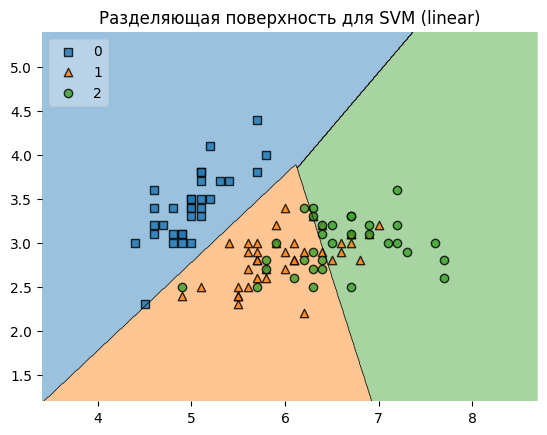

In [ ]:
plot_decision_regions(X_train.values[:, :2], y_train, clf=linear_pipe_svm, legend=2)
plt.title('Разделяющая поверхность для SVM (linear)')

Text(0.5, 1.0, 'Разделяющая поверхность для SVM (rbf)')

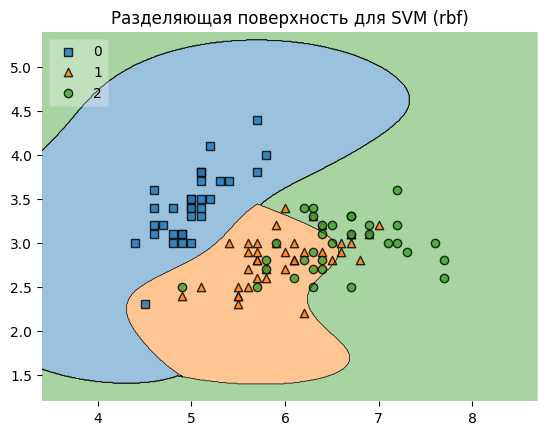

In [ ]:
plot_decision_regions(X_train.values[:, :2], y_train, clf=rbf_pipe_svm, legend=2)
plt.title('Разделяющая поверхность для SVM (rbf)')